In [1]:
import pandas as pd
import numpy as np
import re
import string
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from collections import Counter
from nltk.corpus import stopwords
from nltk import ngrams
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, classification_report
import nltk

In [3]:
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/dhanvidoshi/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/dhanvidoshi/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/dhanvidoshi/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [7]:
# STEP 1: LOAD DATA
df = pd.read_csv("spam.csv", encoding='latin-1')

# Keep only relevant columns
df = df[['v1', 'v2']]
df.columns = ['label', 'message']

# Check the cleaned dataframe
print(df.head())
print(df['label'].value_counts())


  label                                            message
0   ham  Go until jurong point, crazy.. Available only ...
1   ham                      Ok lar... Joking wif u oni...
2  spam  Free entry in 2 a wkly comp to win FA Cup fina...
3   ham  U dun say so early hor... U c already then say...
4   ham  Nah I don't think he goes to usf, he lives aro...
label
ham     4825
spam     747
Name: count, dtype: int64


In [9]:
stop_words = set(stopwords.words('english'))

def preprocess_for_eda(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)  # remove punctuation
    tokens = [word for word in text.split() if word not in stop_words]
    return tokens

# Function to get top n-grams
def get_top_ngrams(corpus, n=1, top_k=10):
    all_ngrams = ngrams([word for text in corpus for word in preprocess_for_eda(text)], n)
    counter = Counter(all_ngrams)
    return counter.most_common(top_k)

In [11]:
spam_texts = df[df['label'] == 'spam']['message']
ham_texts = df[df['label'] == 'ham']['message']

print("Top 10 words in spam:")
print(get_top_ngrams(spam_texts, 1, 10))
print("Top 10 bigrams in spam:")
print(get_top_ngrams(spam_texts, 2, 10))
print("Top 10 trigrams in spam:")
print(get_top_ngrams(spam_texts, 3, 10))

print("\nTop 10 words in ham:")
print(get_top_ngrams(ham_texts, 1, 10))
print("Top 10 bigrams in ham:")
print(get_top_ngrams(ham_texts, 2, 10))
print("Top 10 trigrams in ham:")
print(get_top_ngrams(ham_texts, 3, 10))

Top 10 words in spam:
[(('call',), 347), (('free',), 216), (('2',), 173), (('txt',), 150), (('u',), 147), (('ur',), 144), (('mobile',), 123), (('text',), 120), (('4',), 119), (('claim',), 113)]
Top 10 bigrams in spam:
[(('please', 'call'), 44), (('contact', 'u'), 24), (('po', 'box'), 24), (('å1000', 'cash'), 23), (('guaranteed', 'call'), 23), (('prize', 'guaranteed'), 22), (('send', 'stop'), 19), (('every', 'week'), 19), (('await', 'collection'), 19), (('urgent', 'mobile'), 18)]
Top 10 trigrams in spam:
[(('prize', 'guaranteed', 'call'), 21), (('reply', 'call', '08000930705'), 14), (('land', 'line', 'claim'), 14), (('private', '2003', 'account'), 13), (('2003', 'account', 'statement'), 13), (('guaranteed', 'å1000', 'cash'), 12), (('camcorder', 'reply', 'call'), 12), (('shows', '800', 'unredeemed'), 12), (('free', 'entry', '2'), 11), (('please', 'call', 'customer'), 11)]

Top 10 words in ham:
[(('u',), 972), (('im',), 449), (('2',), 305), (('get',), 303), (('ltgt',), 276), (('ok',), 272

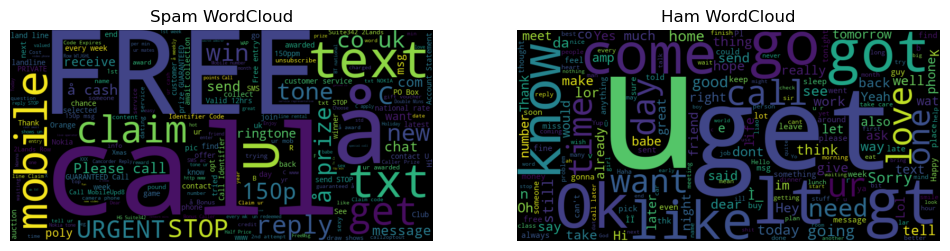

In [13]:
spam_wc = WordCloud(width=800, height=400, stopwords=stop_words, background_color='black').generate(' '.join(spam_texts))
ham_wc = WordCloud(width=800, height=400, stopwords=stop_words, background_color='black').generate(' '.join(ham_texts))

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.imshow(spam_wc, interpolation='bilinear')
plt.title("Spam WordCloud")
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(ham_wc, interpolation='bilinear')
plt.title("Ham WordCloud")
plt.axis('off')
plt.show()

In [14]:
X_train, X_test, y_train, y_test = train_test_split(df['message'], df['label'], test_size=0.2, random_state=42, stratify=df['label'])

bow_vectorizer = CountVectorizer()
X_train_bow = bow_vectorizer.fit_transform(X_train)
X_test_bow = bow_vectorizer.transform(X_test)

model_bow = LogisticRegression(max_iter=1000)
model_bow.fit(X_train_bow, y_train)
y_pred_bow = model_bow.predict(X_test_bow)
f1_bow = f1_score(y_test, y_pred_bow, pos_label='spam')
print("F1-score (BoW):", f1_bow)

F1-score (BoW): 0.9247311827956989


In [17]:
tfidf_vectorizer = TfidfVectorizer()
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

model_tfidf = LogisticRegression(max_iter=1000)
model_tfidf.fit(X_train_tfidf, y_train)
y_pred_tfidf = model_tfidf.predict(X_test_tfidf)
f1_tfidf = f1_score(y_test, y_pred_tfidf, pos_label='spam')
print("F1-score (TF-IDF):", f1_tfidf)

F1-score (TF-IDF): 0.8847583643122676


In [19]:
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    text = text.lower()
    text = re.sub(r'http\S+|www.\S+', '', text)  # remove URLs
    text = re.sub(r'\S+@\S+', '', text)          # remove emails
    text = re.sub(r'<.*?>', '', text)            # remove HTML tags
    text = re.sub(r'\d+', '', text)              # remove numbers
    text = text.translate(str.maketrans('', '', string.punctuation))
    tokens = nltk.word_tokenize(text)
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return ' '.join(tokens)

df['clean_message'] = df['message'].apply(clean_text)

X_train_p, X_test_p, y_train_p, y_test_p = train_test_split(df['clean_message'], df['label'], test_size=0.2, random_state=42, stratify=df['label'])

tfidf_vectorizer_p = TfidfVectorizer()
X_train_tfidf_p = tfidf_vectorizer_p.fit_transform(X_train_p)
X_test_tfidf_p = tfidf_vectorizer_p.transform(X_test_p)

model_tfidf_p = LogisticRegression(max_iter=1000)
model_tfidf_p.fit(X_train_tfidf_p, y_train_p)
y_pred_tfidf_p = model_tfidf_p.predict(X_test_tfidf_p)
f1_tfidf_p = f1_score(y_test_p, y_pred_tfidf_p, pos_label='spam')
print("F1-score (TF-IDF + Preprocessing):", f1_tfidf_p)

LookupError: 
**********************************************************************
  Resource [93mpunkt_tab[0m not found.
  Please use the NLTK Downloader to obtain the resource:

  [31m>>> import nltk
  >>> nltk.download('punkt_tab')
  [0m
  For more information see: https://www.nltk.org/data.html

  Attempted to load [93mtokenizers/punkt_tab/english/[0m

  Searched in:
    - '/Users/dhanvidoshi/nltk_data'
    - '/opt/anaconda3/nltk_data'
    - '/opt/anaconda3/share/nltk_data'
    - '/opt/anaconda3/lib/nltk_data'
    - '/usr/share/nltk_data'
    - '/usr/local/share/nltk_data'
    - '/usr/lib/nltk_data'
    - '/usr/local/lib/nltk_data'
**********************************************************************


In [21]:
print("\n=== Model Comparison ===")
print(f"BoW F1-score: {f1_bow:.4f}")
print(f"TF-IDF F1-score: {f1_tfidf:.4f}")
print(f"TF-IDF + Preprocessing F1-score: {f1_tfidf_p:.4f}")



=== Model Comparison ===
BoW F1-score: 0.9247
TF-IDF F1-score: 0.8848


NameError: name 'f1_tfidf_p' is not defined

In [24]:
import nltk
nltk.download('punkt_tab')


[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/dhanvidoshi/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True